In [1]:
import os
os.chdir("..")


import numpy as np
import hydra

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-04 01:00:49,653	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-04 01:00:49,860	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
INFO:root:using dataset already processed in path C:\Users\ricar\.gluonts\datasets\tourism_monthly.



==== Running experiment for dataset: gluonts_tourism_monthly ====
Loading tourism_monthly dataset...

--- Evaluating for horizon: 18 ---


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



>>> Running model: nbeatsMoe



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | HuberLoss     | 0      | train
1 | valid_loss   | HuberLoss     | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 400 K  | train
-------------------------------------------------------
399 K     Trainable params
1.6 K     Non-trainable params
400 K     Total params
1.602     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Epoch 224: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s, v_num=38, train_loss_step=491.0, train_loss_epoch=1.05e+3, valid_loss=2.75e+3]  

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 24.76it/s]

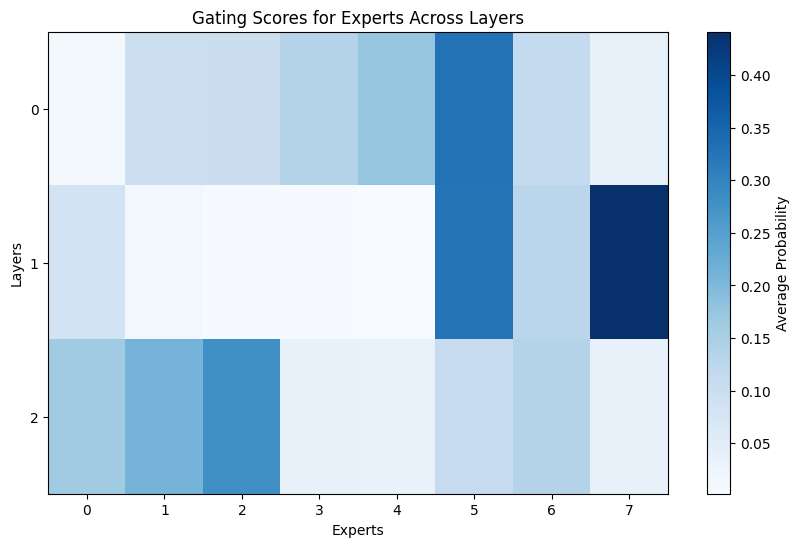

Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 17.80it/s]
Model 'nbeatsMoe' config 0: sMAPE = 0.246
Mean sMAPE for horizon 18: 0.246


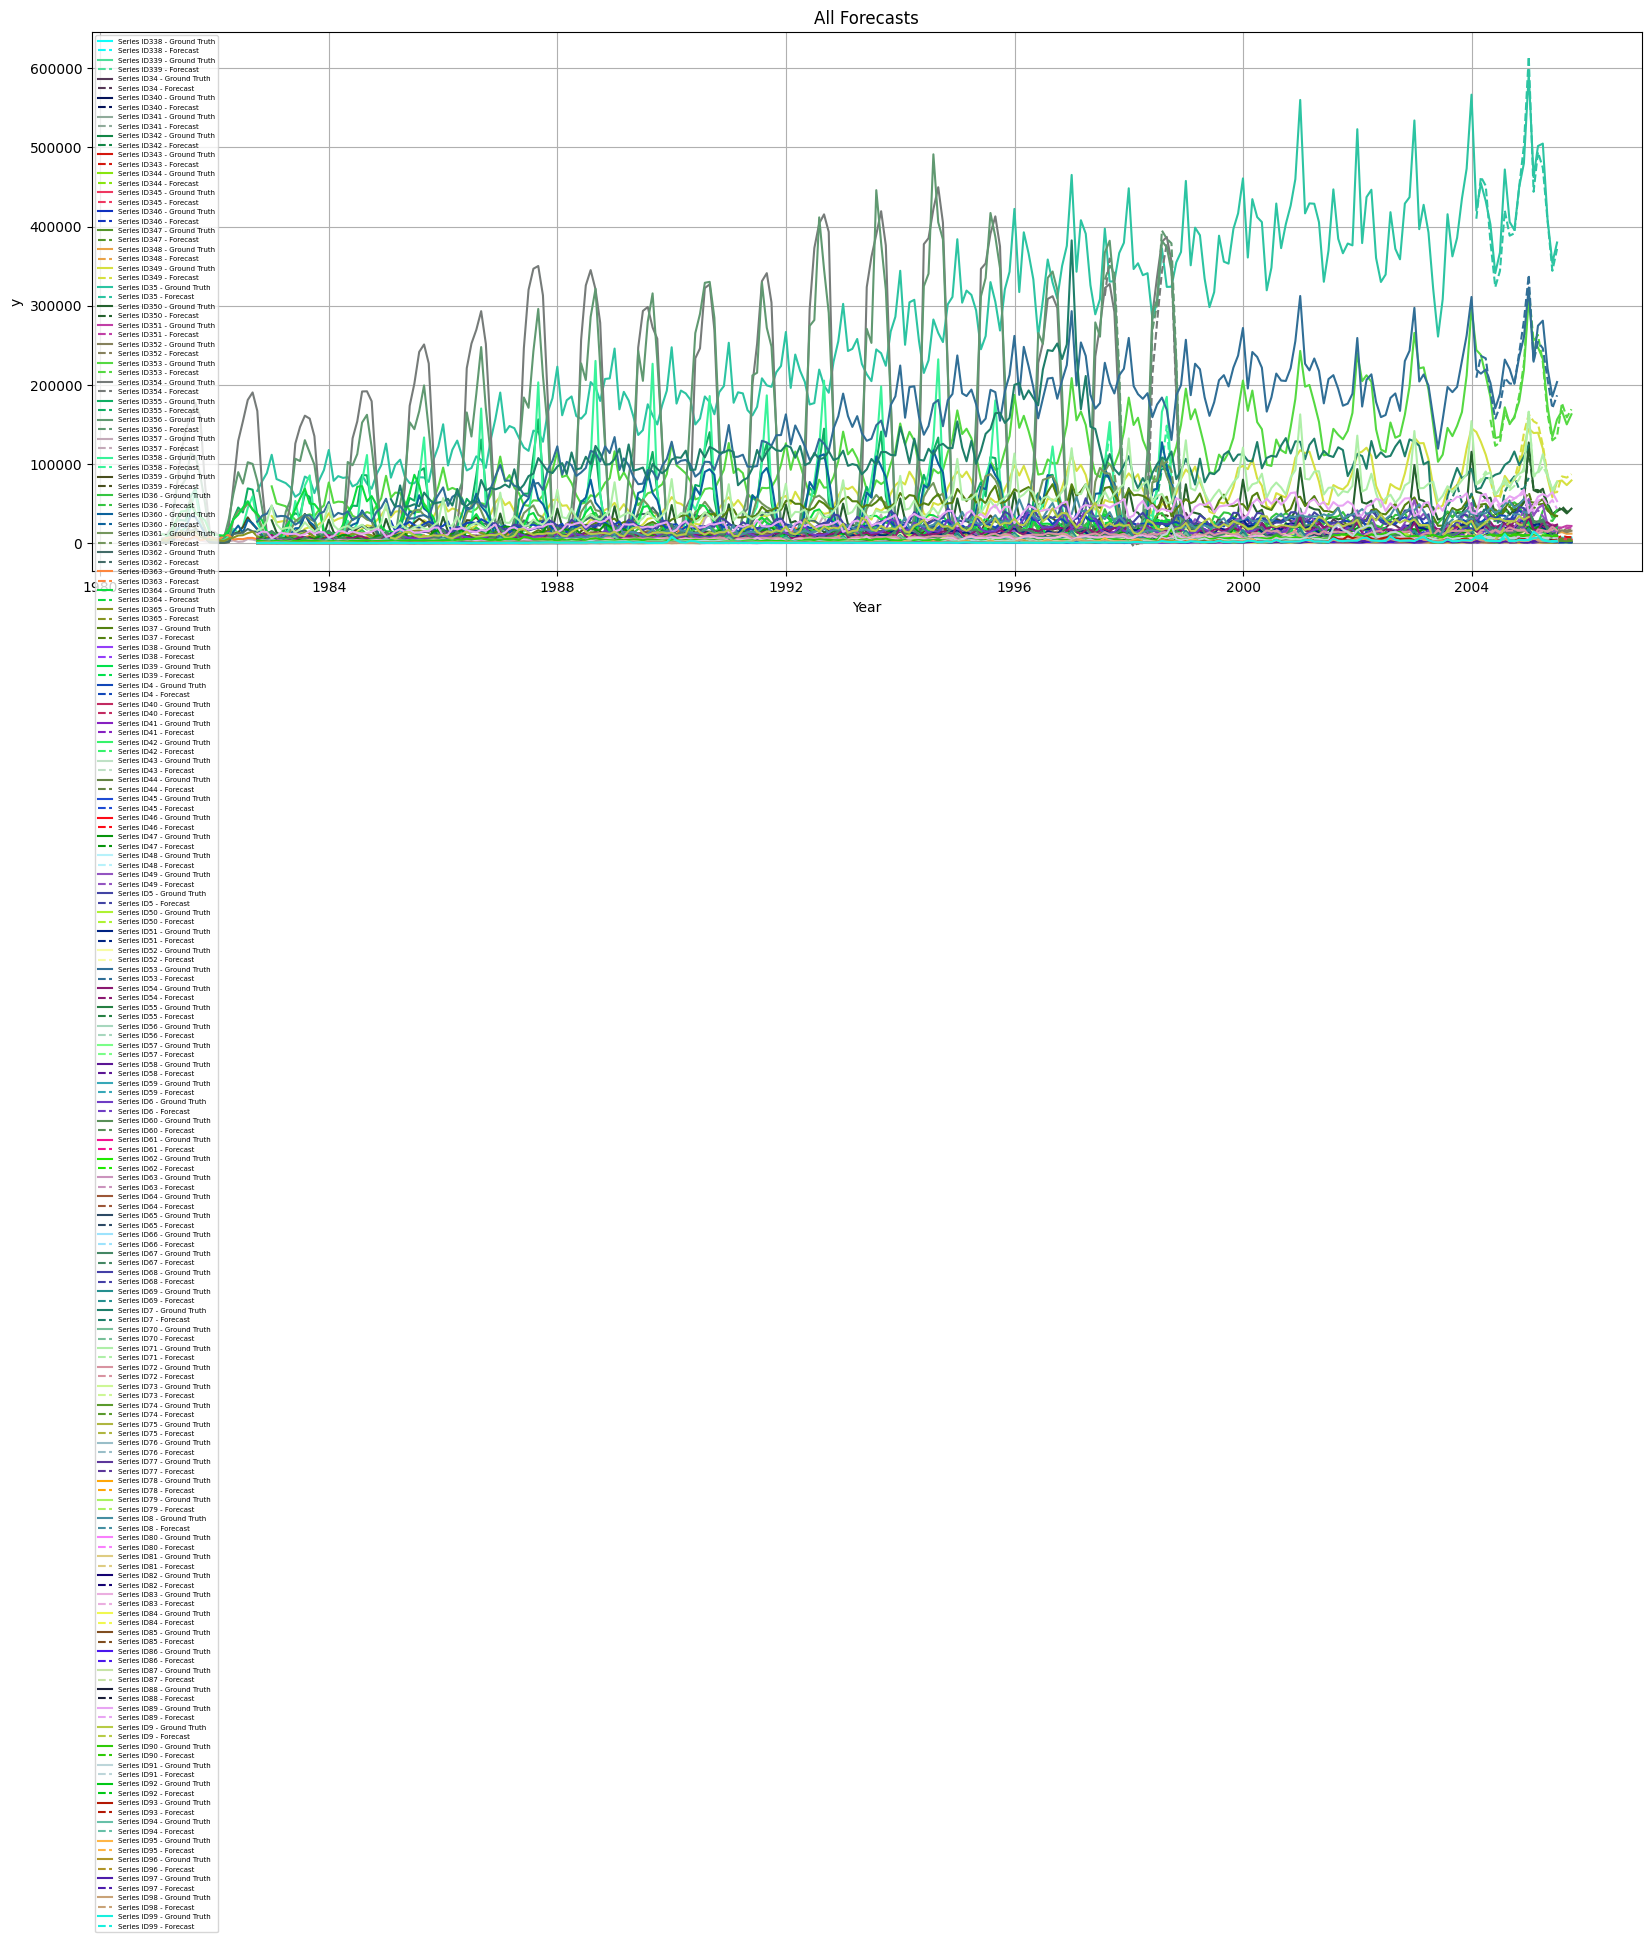

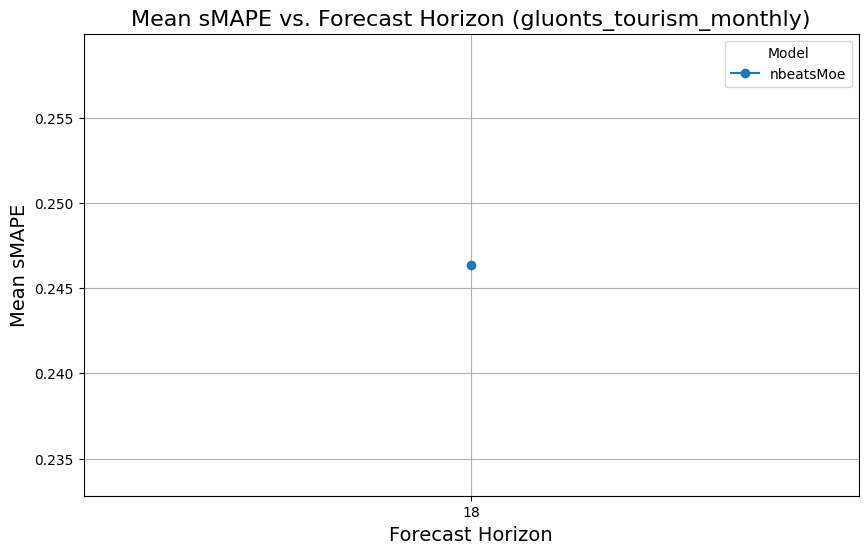

In [2]:
import run_model as utils


def run_all_models():
    hydra.initialize(config_path="./../conf")
    cfg = hydra.compose(config_name="config.yaml")
    
    results, forecasts, callbacks = utils.run_exp(cfg)
    results.to_csv("results.csv", index=False)

    return results, forecasts, callbacks
results, forecasts, callbacks = run_all_models()

In [8]:
import numpy as np
import pandas as pd
from tsfeatures import tsfeatures
from statsmodels.tsa.stattools import acf

In [75]:
# load the gate_values_epoch_0.npy file
gate_values = np.load("gate_values_epoch_0.npy")
all_inputs = np.load("all_inputs_epoch_0.npy")

print("Gate values shape:", gate_values.shape)
print("All inputs shape:", all_inputs.shape)

Gate values shape: (3, 366, 8)
All inputs shape: (3, 366, 24)


In [76]:
# Convert to DataFrame format for tsfeatures
time_series_list = []

for level in range(3):
    print(f"Processing level {level}...")
    for timestep in range(all_inputs.shape[1]):
        df_temp = pd.DataFrame({
            "unique_id": [f"Level_{level}_order_{timestep}"] * all_inputs.shape[2],
            "ds": pd.date_range(start="2000-01-01", periods=all_inputs.shape[2], freq="M"),  # Adjusted periods
            "y": all_inputs[level,timestep, :]
        })
        time_series_list.append(df_temp)

# Combine all series into one DataFrame
df_ts = pd.concat(time_series_list, ignore_index=True)

# Extract features
features = tsfeatures(df_ts, freq=12) 
print(features.head())  # Check extracted features

Processing level 0...
Processing level 1...
Processing level 2...
           unique_id     hurst  series_length  unitroot_pp  unitroot_kpss  \
0    Level_0_order_0  0.697118             24    -9.577836       0.065897   
1    Level_0_order_1  0.788891             24    -9.646272       0.088344   
2   Level_0_order_10  0.763608             24   -11.428443       0.564530   
3  Level_0_order_100  0.736569             24   -18.229758       0.484606   
4  Level_0_order_101  0.832343             24   -10.940876       0.126699   

       hw_alpha       hw_beta      hw_gamma  stability  nperiods  ...  \
0  1.490116e-08  1.489499e-08  8.769706e-17   0.005641         1  ...   
1  1.490116e-08  1.269220e-08  5.495580e-16   0.059982         1  ...   
2  8.666781e-01  8.045056e-17  4.951452e-18   0.414264         1  ...   
3  1.490116e-08  1.490116e-08  0.000000e+00   0.304257         1  ...   
4  1.000000e+00  2.696368e-15  1.303886e-08   0.217985         1  ...   

    entropy  crossing_points  ar

In [77]:
# features = features.drop(columns=["unique_id"])

features.shape


(1098, 43)

Let's first look at level 0 ...

In [78]:
# get all the features from the first level
features_level_0 = features[features["unique_id"].str.contains("Level_0")]
features_level_0

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Level_0_order_0,0.697118,24,-9.577836,0.065897,1.490116e-08,1.489499e-08,8.769706e-17,0.005641,1,...,0.339019,6,1.0,0.667098,1.391253,0.290078,0.268019,-0.188825,0.219162,0.487704
1,Level_0_order_1,0.788891,24,-9.646272,0.088344,1.490116e-08,1.269220e-08,5.495580e-16,0.059982,1,...,0.461361,8,1.0,0.609624,1.228648,-0.029399,0.204311,-0.459036,0.451112,0.414501
2,Level_0_order_10,0.763608,24,-11.428443,0.564530,8.666781e-01,8.045056e-17,4.951452e-18,0.414264,1,...,0.596583,7,1.0,0.465254,0.778678,-0.130195,0.329459,-0.434088,0.244342,0.196767
3,Level_0_order_100,0.736569,24,-18.229758,0.484606,1.490116e-08,1.490116e-08,0.000000e+00,0.304257,1,...,0.807807,9,1.0,0.193112,0.338832,-0.350977,0.287519,-0.629945,0.525103,0.139209
4,Level_0_order_101,0.832343,24,-10.940876,0.126699,1.000000e+00,2.696368e-15,1.303886e-08,0.217985,1,...,0.643734,11,1.0,0.562919,0.822836,0.085783,0.552494,-0.288818,0.731619,0.211336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Level_0_order_95,0.525122,24,-24.641960,0.081394,1.490116e-08,1.488994e-08,0.000000e+00,0.008926,1,...,0.725263,13,1.0,-0.107092,0.400237,-0.395109,0.670842,-0.516268,1.005816,0.283780
362,Level_0_order_96,0.745905,24,-12.050068,0.122215,6.727350e-01,6.003323e-16,2.565286e-16,0.037265,1,...,0.713349,8,1.0,0.397500,0.347454,-0.280379,0.225551,-0.494928,0.496835,0.257998
363,Level_0_order_97,0.755668,24,-11.622205,0.472667,6.492566e-01,0.000000e+00,0.000000e+00,0.169562,1,...,0.727558,11,1.0,0.424041,0.302953,-0.263124,0.377057,-0.457448,0.498147,0.337118
364,Level_0_order_98,0.640989,24,-20.078828,0.305952,1.490116e-08,1.434676e-10,6.241332e-18,0.073152,1,...,0.700098,3,1.0,0.133027,0.158788,-0.487869,0.248555,-0.656846,0.458911,0.448014


In [79]:
gate_probs_at_0 = gate_values[0, :, :]
gate_probs_at_0.shape

(366, 8)

In [80]:
# add the gate probabilities to the features dataframe... one column for each expert
features_level_0 = features_level_0.copy()
for i in range(gate_probs_at_0.shape[1]):
    features_level_0[f"gate_prob_{i}"] = gate_probs_at_0[:, i]

features_level_0.head(10)  # Check the first 10 rows of the updated DataFrame

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff2_acf10,seas_acf1,gate_prob_0,gate_prob_1,gate_prob_2,gate_prob_3,gate_prob_4,gate_prob_5,gate_prob_6,gate_prob_7
0,Level_0_order_0,0.697118,24,-9.577836,0.065897,1.490116e-08,1.489499e-08,8.769706e-17,0.005641,1,...,0.219162,0.487704,0.000000,0.000000,0.368327,0.000000,0.0,0.000000,0.631673,0.000000
1,Level_0_order_1,0.788891,24,-9.646272,0.088344,1.490116e-08,1.269220e-08,5.495580e-16,0.059982,1,...,0.451112,0.414501,0.476062,0.000000,0.000000,0.000000,0.0,0.000000,0.523938,0.000000
2,Level_0_order_10,0.763608,24,-11.428443,0.564530,8.666781e-01,8.045056e-17,4.951452e-18,0.414264,1,...,0.244342,0.196767,0.000000,0.208097,0.791903,0.000000,0.0,0.000000,0.000000,0.000000
3,Level_0_order_100,0.736569,24,-18.229758,0.484606,1.490116e-08,1.490116e-08,0.000000e+00,0.304257,1,...,0.525103,0.139209,0.000000,0.000000,0.000000,0.000000,0.0,0.235956,0.764044,0.000000
4,Level_0_order_101,0.832343,24,-10.940876,0.126699,1.000000e+00,2.696368e-15,1.303886e-08,0.217985,1,...,0.731619,0.211336,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.682706,0.317294
5,Level_0_order_102,0.770767,24,-14.695051,0.507422,4.882037e-01,2.606266e-17,2.676844e-17,0.194300,1,...,0.467469,0.355439,0.000000,0.000000,0.000000,0.000000,0.0,0.543213,0.456787,0.000000
6,Level_0_order_103,0.852161,24,-6.619533,0.209128,1.490116e-08,1.489034e-08,2.793444e-17,0.000695,1,...,0.704680,0.481882,0.000000,0.000000,0.000000,0.454158,0.0,0.545842,0.000000,0.000000
7,Level_0_order_104,0.721997,24,-14.626428,0.291066,4.106104e-01,4.654132e-18,0.000000e+00,0.042468,1,...,0.558241,0.461536,0.000000,0.000000,0.000000,0.000000,0.0,0.352313,0.647687,0.000000
8,Level_0_order_105,0.800209,24,-12.637881,0.201816,1.490116e-08,2.946989e-10,5.487763e-16,0.006698,1,...,0.502855,0.452166,0.000000,0.000000,0.000000,0.552562,0.0,0.447438,0.000000,0.000000
9,Level_0_order_106,0.566921,24,-16.041289,0.058152,1.490116e-08,1.489765e-08,1.276888e-16,0.015403,1,...,0.397260,0.443272,0.000000,0.000000,0.000000,0.469305,0.0,0.530695,0.000000,0.000000


In [81]:
# calculate the correlation matrix
copy_features_level_0 = features_level_0.copy()
copy_features_level_0 = copy_features_level_0.drop(columns=["unique_id"])
correlation_matrix = copy_features_level_0.corr()
correlation_matrix

,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,seasonal_period,...,diff2_acf10,seas_acf1,gate_prob_0,gate_prob_1,gate_prob_2,gate_prob_3,gate_prob_4,gate_prob_5,gate_prob_6,gate_prob_7
hurst,1.000000,NaN,0.654990,0.152763,0.364471,0.050475,0.045872,0.294766,NaN,NaN,...,-0.012588,-0.128856,0.050511,-0.004511,-0.047409,0.125729,-0.058622,-0.022976,-0.022163,0.051514
series_length,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unitroot_pp,0.654990,NaN,1.000000,0.130294,0.349471,0.034725,0.085337,0.086881,NaN,NaN,...,-0.301247,0.170326,0.068769,0.002966,-0.043520,0.048348,-0.058070,0.059688,-0.082735,0.070196
unitroot_kpss,0.152763,NaN,0.130294,1.000000,0.107320,-0.003522,0.016948,0.576524,NaN,NaN,...,-0.012506,-0.234857,0.017768,-0.079893,0.137271,-0.049916,-0.144566,0.031193,0.048159,0.101506
hw_alpha,0.364471,NaN,0.349471,0.107320,1.000000,0.183051,0.113434,0.161569,NaN,NaN,...,-0.023821,-0.218155,-0.056857,0.066921,-0.032165,0.023419,-0.097113,0.041406,-0.044498,0.101134
hw_beta,0.050475,NaN,0.034725,-0.003522,0.183051,1.000000,-0.014815,0.073819,NaN,NaN,...,0.004163,-0.011895,-0.039056,-0.100638,0.025161,0.003858,0.043557,0.008553,0.006885,0.016644
hw_gamma,0.045872,NaN,0.085337,0.016948,0.113434,-0.014815,1.000000,-0.032389,NaN,NaN,...,-0.021814,0.064173,-0.010000,-0.001461,-0.030327,0.087765,-0.044657,-0.052409,-0.030404,0.172961
stability,0.294766,NaN,0.086881,0.576524,0.161569,0.073819,-0.032389,1.000000,NaN,NaN,...,0.056304,-0.537237,-0.014722,-0.122496,0.088261,-0.001000,-0.050103,0.017518,-0.001109,0.121394
nperiods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasonal_period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


lets remove all Nan values ...

In [82]:
correlation_matrix = correlation_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

Time to check the correlations ...

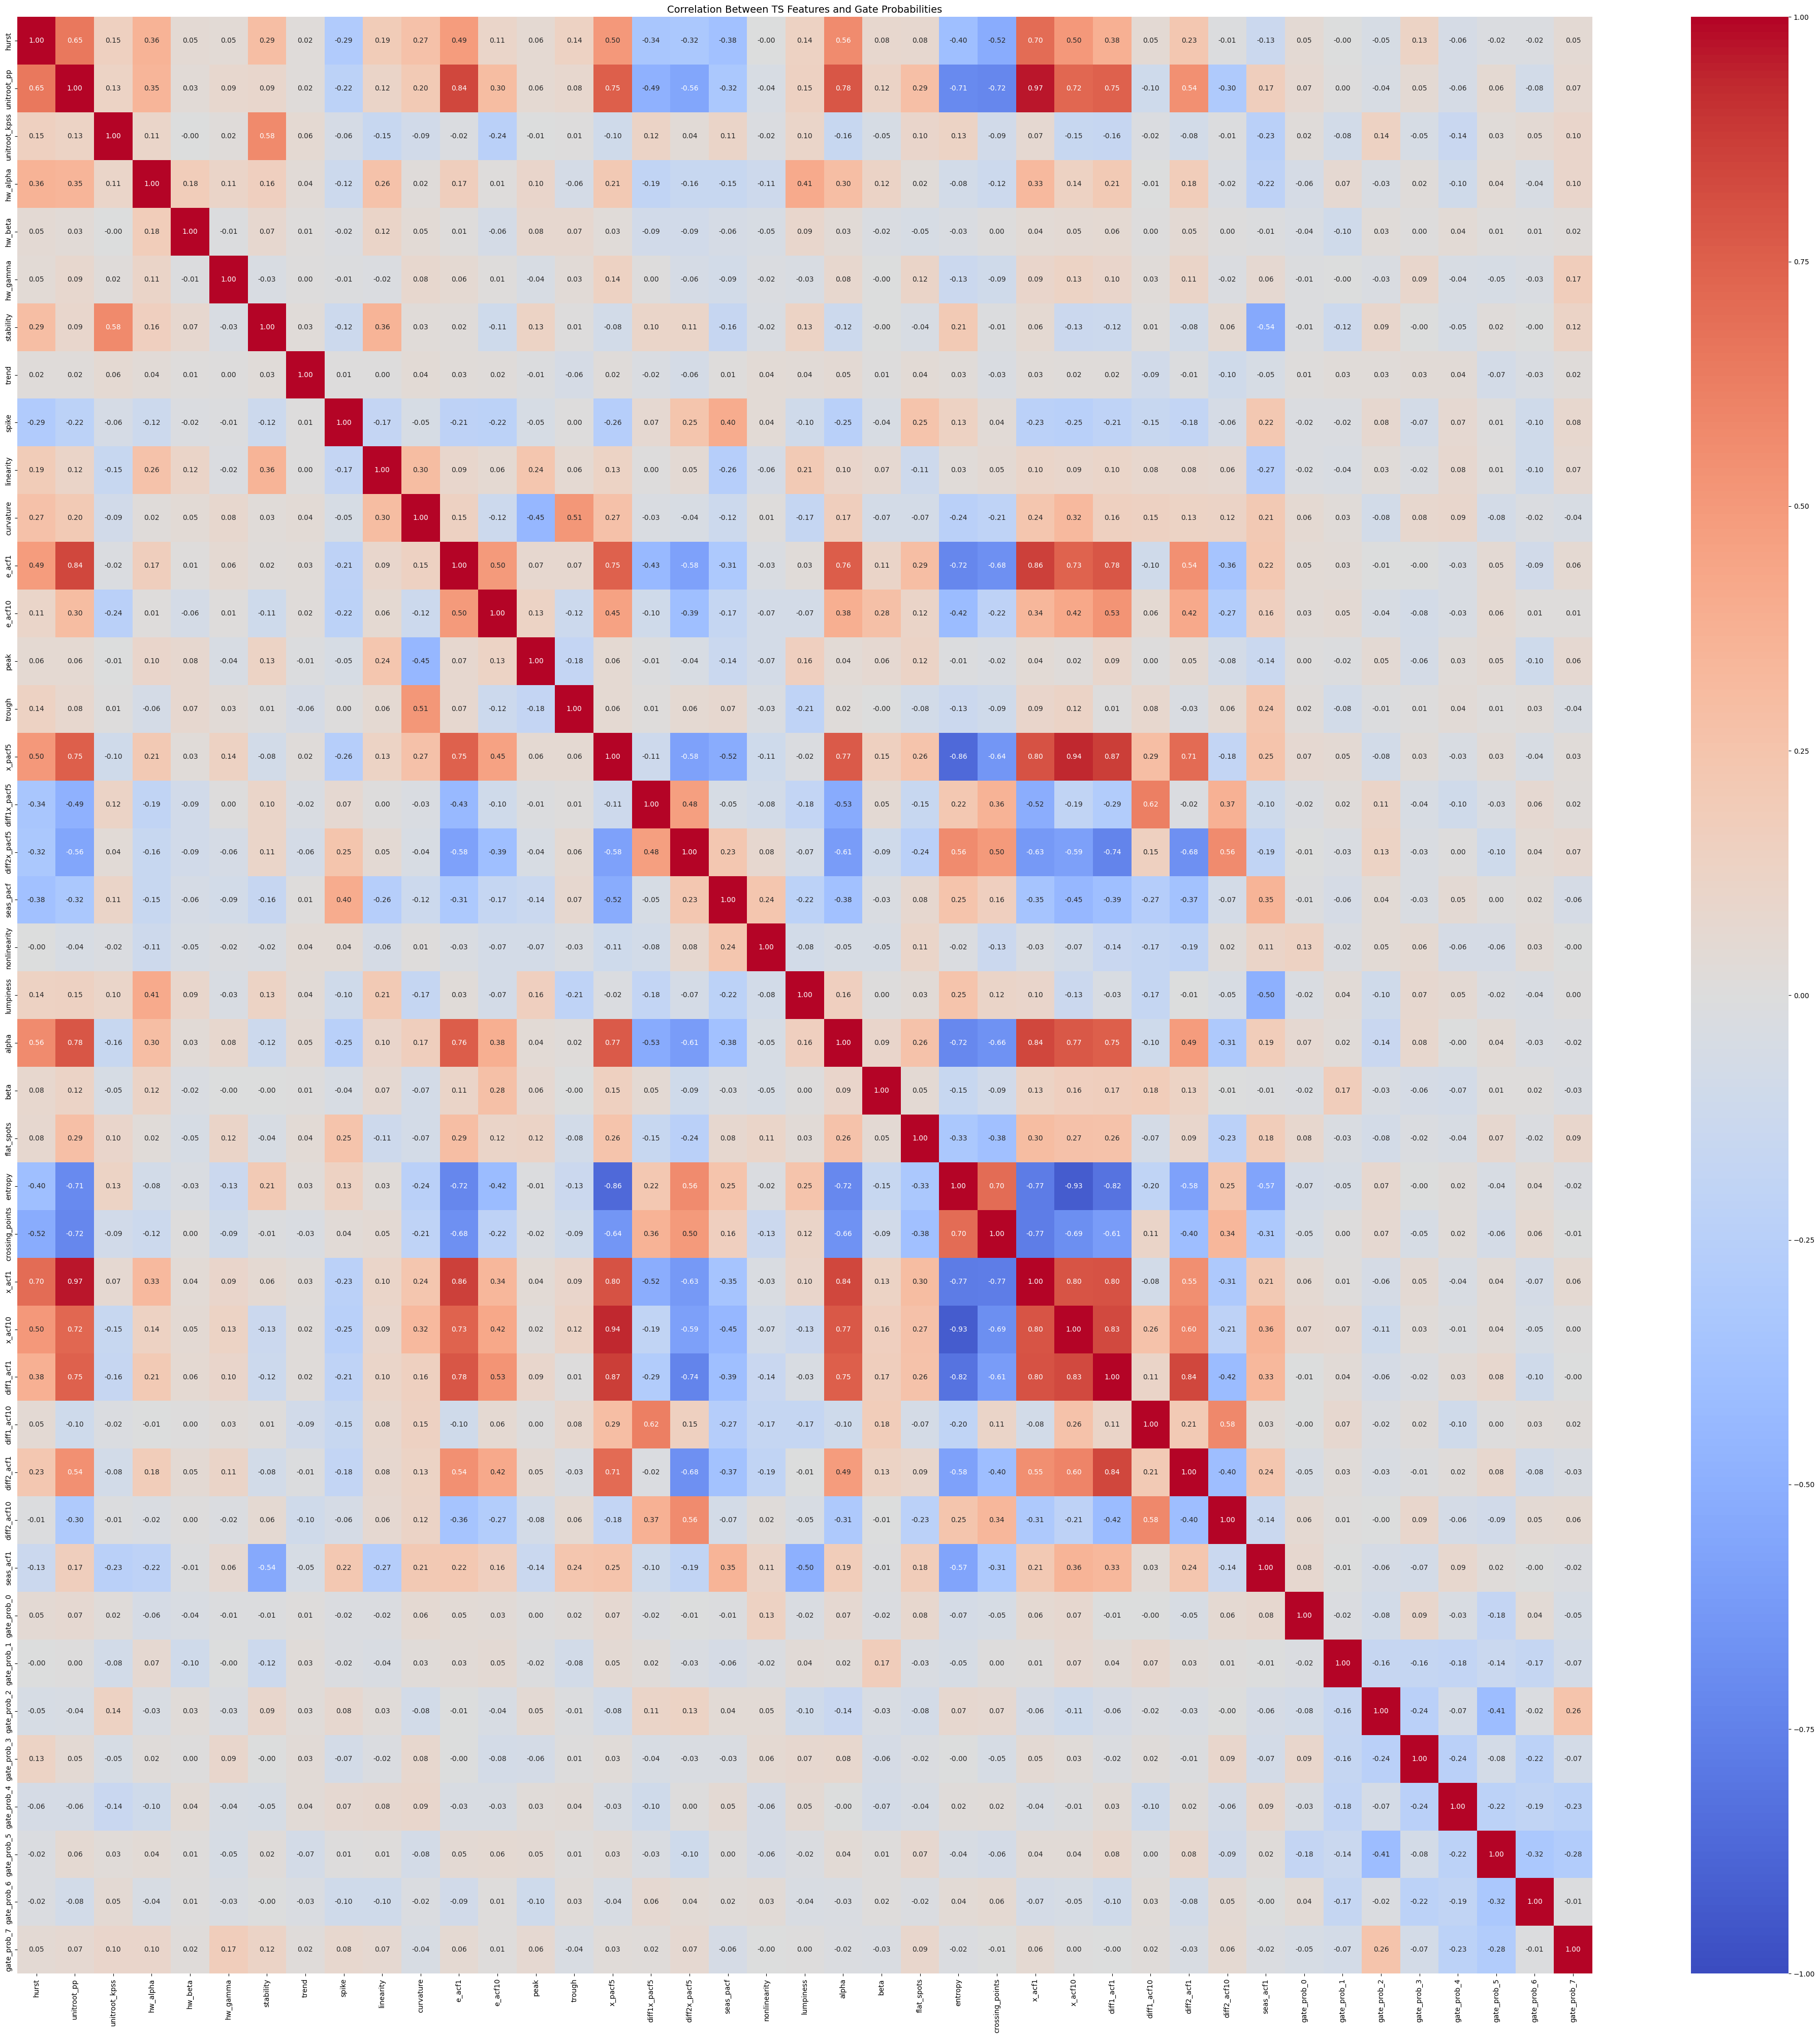

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(50, 50))

# Create heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    fmt=".2f",  # Limit decimal places
    cmap="coolwarm",  # Use diverging color map
    linewidths=0.0,  # Add gridlines
    vmin=-1, vmax=1  # Normalize color scale
)

# Title
plt.title("Correlation Between TS Features and Gate Probabilities", fontsize=14)

# Show plot
plt.show()


Now mutual information ... 

In [84]:
# calculate the mutual information between the features and the gate probabilities
from sklearn.feature_selection import mutual_info_regression

# Extract features and gates
features_columns = [col for col in features_level_0.columns if not "gate_" in col]  # Adjust this if needed
gate_columns = [col for col in features_level_0.columns if "gate_" in col]  # Adjust this if needed

df_features = features_level_0[features_columns]  # Features
df_gates = features_level_0[gate_columns]  # Gate probabilities

df_features = df_features.drop(columns=["unique_id"])


In [89]:
# print nan values in the features dataframe
nan_columns = df_features.columns[df_features.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Drop NaN values
df_features = df_features.dropna(axis=0, how='all').dropna(axis=1, how='all')

Columns with NaN values: ['hurst']


In [91]:
df_features = df_features.drop(columns=["hurst"])

In [92]:
mi_results = {}

for gate in df_gates.columns:  # Loop through each expert (gate)
    
    mi_score = mutual_info_regression(df_features, df_gates[gate])  # Calculate MI
    mi_results[gate] = mi_score  # Store MI results for each gate

# Convert MI results into a DataFrame
mi_df = pd.DataFrame(mi_results, index=df_features.columns)

# Display the Mutual Information results
print(mi_df)

                   gate_prob_0  gate_prob_1  gate_prob_2  gate_prob_3  \
series_length         0.000000     0.000000     0.000000     0.002100   
unitroot_pp           0.000078     0.000000     0.028490     0.003040   
unitroot_kpss         0.003565     0.000000     0.044596     0.004154   
hw_alpha              0.028737     0.000000     0.027731     0.000000   
hw_beta               0.000000     0.000000     0.000000     0.001484   
hw_gamma              0.000000     0.021455     0.000000     0.028044   
stability             0.000000     0.012829     0.000000     0.007114   
nperiods              0.000000     0.000000     0.000000     0.000000   
seasonal_period       0.000000     0.026812     0.087861     0.000000   
trend                 0.000000     0.000000     0.034485     0.015336   
spike                 0.019291     0.000000     0.000000     0.002877   
linearity             0.000000     0.016873     0.000000     0.000000   
curvature             0.021832     0.003192     0.0

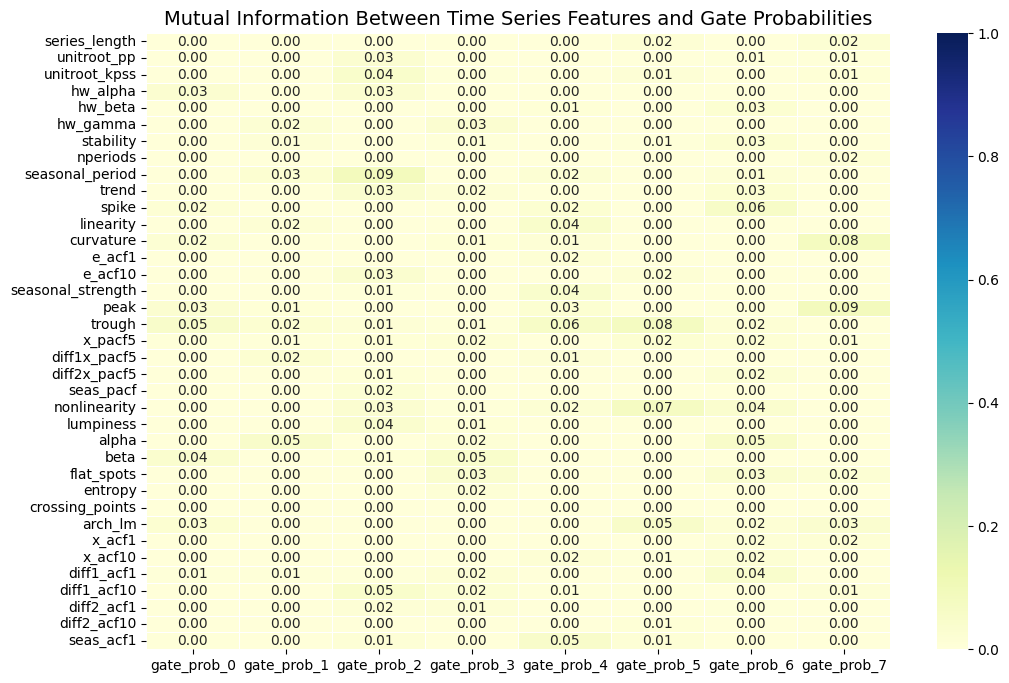

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Mutual Information heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mi_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, vmin=0, vmax=1)

# Add title and labels
plt.title("Mutual Information Between Time Series Features and Gate Probabilities", fontsize=14)

# Show plot
plt.show()
